# Baseline for CNN for MNIST_small (for comparison with Chad's method)

import sys
sys.path.append('../../')
from layer_for_theano import *

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import cPickle
import numpy as np
import gzip

import time

class dataset_mnist_small_3d:
    def __init__(self):
        if 0: # no requirement for gzip, but big file
            f = open('mnist_14x14.pkl', 'rb')
            train_set, valid_set, test_set = cPickle.load(f)
            f.close()
        else: # requiring gzip           
            f = gzip.open('mnist_14x14.pkl.gz','rb')
            train_set, valid_set, test_set = cPickle.load(f)
            f.close()

        xs_tr, ys_tr = train_set
        xs_val, ys_val = valid_set
        xs_te, ys_te = test_set
        
        self.xs_tr = xs_tr.reshape(xs_tr.shape[0],1,14,14)
        self.xs_te = xs_te.reshape(xs_te.shape[0],1,14,14)
        self.xs_val = xs_val.reshape(xs_val.shape[0],1,14,14)       

        self.ys_tr =  ys_tr.astype(np.int32)
        self.ys_val = ys_val.astype(np.int32)
        self.ys_te =  ys_te.astype(np.int32)

t0 = time.time()
        
ds =  dataset_mnist_small_3d()  
print 'load dataset in %.1f secs' % (time.time()-t0)

print ds.xs_tr.shape


load dataset in 2.8 secs
(50000L, 1L, 14L, 14L)


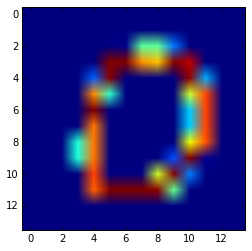

In [15]:
plt.imshow(ds.xs_te[10,0])
plt.show()

In [24]:
from sgd_for_theano import *
class cnn_small(tt_sgd_model):
    def __init__(self):
        #784
        #dim = 196
        nc = 10

        self.layers = []
        self.layers += [Input2DLayer(500, 1, 14, 14)]

        nonlinearfunc = T.tanh #T.nnet.sigmoid #rectify #rectify
        print 'nonlinear activation function = ', nonlinearfunc
        
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[20,1,3,3], activation=nonlinearfunc)]
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[50,20,3,3], activation=nonlinearfunc)]
        
        #self.layers += [ HiddenLayer(self.layers[-1], n_out = 500,  activation = T.tanh)]
        #self.layers += [ HiddenLayer(self.layers[-1], n_out = nc,  activation = None)]
        
        self.layers += [FlattenLayer(self.layers[-1])]
        self.layers += [HiddenLayer(self.layers[-1], n_out = 900, activation=nonlinearfunc)]
        self.layers += [HiddenLayer(self.layers[-1], n_out = 10)]
        
        self.layers +=  [ SoftmaxLayer(self.layers[-1])]

        target = T.ivector('target')
        output_eval = self.layers[-1].output()
        self.cost_eval = mcloss_negli(output_eval, target)
        self.err_eval = mc_error(output_eval, target)
        self.validate_model = theano.function([self.layers[0].input, target], self.err_eval)
        self.cost_model = theano.function([self.layers[0].input, target], self.cost_eval)

        output_tr = self.layers[-1].output(dropout_training=True)
        self.cost_tr = mcloss_negli(output_eval, target)

        #learning_rate = 0.13
        learning_rate = 0.05
        #all_para = all_parameters(self.layers[-1])
        all_para = self.get_all_parameters()
        updates = gen_updates_sgd(self.cost_tr, all_para, learning_rate)
        self.train_model = theano.function([self.layers[0].input, target], self.cost_tr, updates=updates)

model = cnn_small()

if 1: #unit test
    import sys
    model._unit_test(ds.xs_tr[0:100], ds.ys_tr[0:100])
    #sys.exit(0)

nonlinear activation function =  Elemwise{tanh,no_inplace}
before training, err= 0.84
now training, cost =  2.31700022349
after training, err= 0.59


In [25]:
best_err, best_model,err_list_val, err_list_tr =  sgd_batch(model, ds.xs_tr, ds.ys_tr, ds.xs_te, ds.ys_te, batch_size=600, n_epochs=10, verbose=2)

2.14132844892 1.91101169299 1.79257733582 1.72504972667 1.60370653837 1.55171850317 1.55832859059 1.49597019269 1.46257795314 1.45551863803 1.41856492684 1.38545265185 1.38515213503 1.37350789908 1.3537376623 1.30793203838 1.35277029444 1.31796231632 1.3130728109 1.29857470746 1.32179478496 1.26851781168 1.27201044749 1.25510201743 1.24744173608 1.2513125074 1.25859486476 1.272937657 1.22667232976 1.21076521591 1.23281513329 1.22993376118 1.24264525181 1.19792721179 1.18176095547 1.22293760846 1.19924506482 1.20849938102 1.20441891951 1.19977192702 1.18218988647 1.18333952882 1.19639956008 1.17584650096 1.17750998191 1.16350154974 1.17756660433 1.1873458565 1.15459744396 1.15984784124 1.16463601973 1.1784551545 1.15464997809 1.15983210156 1.15931952766 1.13125399555 1.17303753128 1.1214401557 1.17548311271 1.14364608338 1.14566753786 1.16374844082 1.16585172724 1.12550062241 1.12977863965 1.16248449332 1.1798097754 1.15278811078 1.15240291399 1.10374396629 1.12275087655 1.13763961027 1

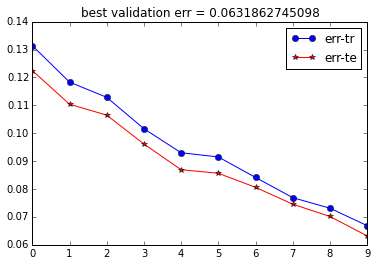

In [26]:

plt.plot(err_list_tr,'bo-',label='err-tr')
plt.plot(err_list_val,'r*-',label='err-te')
plt.legend()
plt.title('best validation err = ' + str(best_err))
plt.show()